<a href="https://colab.research.google.com/github/boomyun713/114_homework/blob/main/%E6%9C%9F%E6%9C%AB%E5%B0%88%E9%A1%8Cgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install yfinance -q

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
tickers = ["VST", "APP", "NVDA", "LLY"]
train_start = "2021-01-01"
train_end   = "2024-12-31"
test_start  = "2025-01-01"
test_end    = "2025-12-01"
raw_data_train = {}
raw_data_test  = {}

In [ ]:
for t in tickers:
    print(f"Downloading {t} from Yahoo Finance (train period)...")
    df_train = yf.download(t, start=train_start, end=train_end)
    raw_data_train[t] = df_train

    print(f"Downloading {t} from Yahoo Finance (test period)...")
    df_test = yf.download(t, start=test_start, end=test_end)
    raw_data_test[t] = df_test

print("下載完成！")

/tmp/ipython-input-1631639775.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_train = yf.download(t, start=train_start, end=train_end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1631639775.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(t, start=test_start, end=test_end)
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-1631639775.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_train = yf.download(t, start=train_start, end=train_end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1631639775.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(t, start=test_start, end=test_end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1631639775.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_train = yf.download(t, start=train_start, end=train_end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1631639775.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(t, start=test_start, end=test_end)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1631639775.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_train = yf.download(t, start=train_start, end=train_end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1631639775.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(t, start=test_start, end=test_end)


[*********************100%***********************]  1 of 1 completed

下載完成！


In [ ]:
def add_technical_indicators(df, ma_windows=[20, 60]):
    df = df.copy()
    close = df['Close']
    for w in ma_windows:
        df[f'MA{w}'] = close.rolling(window=w).mean()

    delta = close.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    window = 14
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    df['RSI14'] = 100 - (100 / (1 + rs))

    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    bb_window = 20
    df['BB_MA20'] = close.rolling(window=bb_window).mean()
    df['BB_STD20'] = close.rolling(window=bb_window).std()
    df['BB_upper'] = df['BB_MA20'] + 2 * df['BB_STD20']
    df['BB_lower'] = df['BB_MA20'] - 2 * df['BB_STD20']

    return df

In [ ]:
def score_stock(latest_row):
    score = 0

    close     = latest_row['Close']
    ma60      = latest_row['MA60']
    rsi       = latest_row['RSI14']
    macd_hist = latest_row['MACD_hist']
    bb_upper  = latest_row['BB_upper']
    if pd.notna(ma60) and close > ma60:
        score += 1

    if pd.notna(macd_hist) and macd_hist > 0:
        score += 1

    if pd.notna(rsi) and 50 <= rsi <= 70:
        score += 1

    if pd.notna(bb_upper) and close <= bb_upper:
        score += 1

    if score >= 3:
        view = "樂觀（偏多）"
    elif score == 2:
        view = "中立"
    else:
        view = "偏保守 / 悲觀"

    return score, view

In [ ]:
def score_stock(latest_row):
    score = 0

    # Ensure all extracted values are scalars by using .item() if they are Series.
    close     = latest_row['Close'].item()
    ma60      = latest_row['MA60'].item()
    rsi       = latest_row['RSI14'].item()
    macd_hist = latest_row['MACD_hist'].item()
    bb_upper  = latest_row['BB_upper'].item()

    if pd.notna(ma60) and close > ma60:
        score += 1

    if pd.notna(macd_hist) and macd_hist > 0:
        score += 1

    if pd.notna(rsi) and 50 <= rsi <= 70:
        score += 1

    if pd.notna(bb_upper) and close <= bb_upper:
        score += 1

    if score >= 3:
        view = "樂觀（偏多）"
    elif score == 2:
        view = "中立"
    else:
        view = "偏保守 / 悲觀"

    return score, view

summary_rows = []

for t in tickers:
    print(f"\n處理 {t} 的訓練資料（2021–2024）...")
    # Added check for missing data
    if t not in raw_data_train:
        print(f"警告：找不到 {t} 的訓練資料。請確認資料下載步驟已成功執行（cell 1laOP_ayIFLt）。跳過此股票。")
        continue

    df_train = raw_data_train[t].copy()

    df_train = add_technical_indicators(df_train)

    df_2024 = df_train.loc[:train_end]

    if df_2024.empty:
        print(f"{t} 在 {train_start}~{train_end} 無資料，略過")
        continue

    latest_row = df_2024.iloc[-1]
    latest_date = df_2024.index[-1]

    score, view = score_stock(latest_row)

    summary_rows.append({
        "Ticker": t,
        "RefDate_for_signal": latest_date.date(),
        "Close_Ref": latest_row['Close'].item(), # Also ensure this is a scalar
        "Score": score,
        "Model_View_2024": view
    })

summary_df = pd.DataFrame(summary_rows)

print("\n=== 2024 年底技術面評分 & 樂觀/悲觀判斷（模型輸出） ===")
display(summary_df)


處理 VST 的訓練資料（2021–2024）...

處理 APP 的訓練資料（2021–2024）...

處理 NVDA 的訓練資料（2021–2024）...

處理 LLY 的訓練資料（2021–2024）...

=== 2024 年底技術面評分 & 樂觀/悲觀判斷（模型輸出） ===


,Ticker,RefDate_for_signal,Close_Ref,Score,Model_View_2024
0,VST,2024-12-30,139.521103,2,中立
1,APP,2024-12-30,335.380005,2,中立
2,NVDA,2024-12-30,137.452393,2,中立
3,LLY,2024-12-30,768.110779,2,中立


In [ ]:
backtest_rows = []

for t in tickers:
    print(f"\n回測 {t} 2025 年走勢...")
    # Added check for missing data in raw_data_test
    if t not in raw_data_test:
        print(f"警告：找不到 {t} 的測試資料。請確認資料下載步驟已成功執行（cell 1laOP_ayIFLt）。跳過此股票。")
        continue

    df_test = raw_data_test[t]

    if df_test.empty or len(df_test) < 2:
        print(f"{t} 2025 年資料太少，無法回測")
        continue

    entry_price = df_test['Close'].iloc[0].item()
    exit_price  = df_test['Close'].iloc[-1].item()
    ret_pct = (exit_price / entry_price - 1) * 100

    backtest_rows.append({
        "Ticker": t,
        "Entry_2025_Date": df_test.index[0].date(),
        "Entry_2025_Close": entry_price,
        "Exit_2025_Date": df_test.index[-1].date(),
        "Exit_2025_Close": exit_price,
        "Return_2025_%": ret_pct
    })

backtest_df = pd.DataFrame(backtest_rows)

print("\n=== 2025 年實際績效（簡單持有回測結果） ===")
display(backtest_df)


回測 VST 2025 年走勢...

回測 APP 2025 年走勢...

回測 NVDA 2025 年走勢...

回測 LLY 2025 年走勢...

=== 2025 年實際績效（簡單持有回測結果） ===


,Ticker,Entry_2025_Date,Entry_2025_Close,Exit_2025_Date,Exit_2025_Close,Return_2025_%
0,VST,2025-01-02,149.052246,2025-11-28,178.860001,19.998192
1,APP,2025-01-02,341.779999,2025-11-28,599.479980,75.399375
2,NVDA,2025-01-02,138.272171,2025-11-28,176.990143,28.001276
3,LLY,2025-01-02,772.309448,2025-11-28,1075.469971,39.253763


In [ ]:
if not summary_df.empty:
    result_df = pd.merge(summary_df, backtest_df, on="Ticker", how="left")

    print("\n=== 模型觀點（2024 年底） vs 2025 年實際報酬 ===")
    display(result_df)
    best_score = result_df['Score'].max()
    best_by_score = result_df[result_df['Score'] == best_score]

    print("\n=== 依 2024 年底技術指標，模型最看好的標的（Score 最高） ===")
    display(best_by_score.sort_values("Return_2025_%", ascending=False))
else:
    print("警告：由於訓練資料處理失敗，summary_df 為空。無法進行合併和分析。請檢查之前的步驟並重新執行下載和處理資料的單元格。")
    # Optionally create an empty result_df if it's used later
    result_df = pd.DataFrame()

警告：由於訓練資料處理失敗，summary_df 為空。無法進行合併和分析。請檢查之前的步驟並重新執行下載和處理資料的單元格。



繪製 NVDA 2021–2024 的價格與技術指標圖...


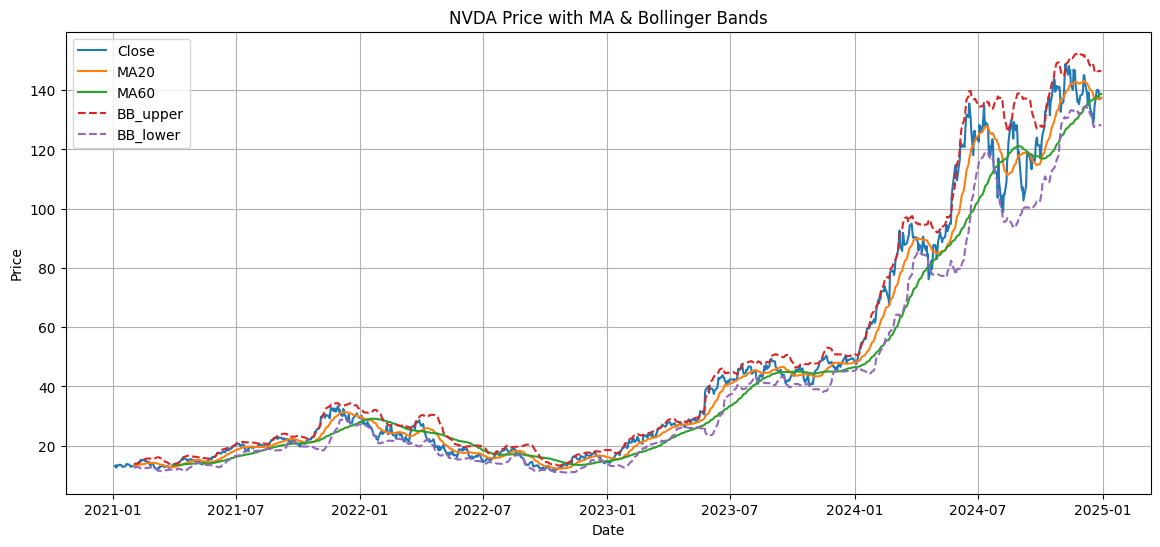

In [ ]:
def plot_with_indicators(ticker, df, start_date=None, end_date=None):
    df_plot = df.copy()
    df_plot = add_technical_indicators(df_plot)

    # 篩選時間區間（如果有給）
    if start_date is not None:
        df_plot = df_plot.loc[start_date:]
    if end_date is not None:
        df_plot = df_plot.loc[:end_date]

    plt.figure(figsize=(14, 6))
    plt.plot(df_plot.index, df_plot['Close'], label='Close')
    plt.plot(df_plot.index, df_plot['MA20'], label='MA20')
    plt.plot(df_plot.index, df_plot['MA60'], label='MA60')
    plt.plot(df_plot.index, df_plot['BB_upper'], linestyle='--', label='BB_upper')
    plt.plot(df_plot.index, df_plot['BB_lower'], linestyle='--', label='BB_lower')

    plt.title(f"{ticker} Price with MA & Bollinger Bands")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n繪製 NVDA 2021–2024 的價格與技術指標圖...")
plot_with_indicators("NVDA", raw_data_train["NVDA"], start_date=train_start, end_date=train_end)